<a href="https://colab.research.google.com/github/PierreCasco/twitter_and_football/blob/master/Twitter_and_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import tweepy
import jsonpickle

In [0]:
CONSUMER_KEY = 'BSgqFZrPFuabZcbeee8gOf778'
CONSUMER_SECRET = 'D8FbZlY9mjlqGurCCcgT4osp5kNCdy2ZQ7SkfDqZYrZbeFP6sD'
OAUTH_TOKEN = '323252972-uKcBf2Us0uUAuSP79P7xwWFAv6WwebgXmYoyVi5L'
OAUTH_SECRET = 'QE6tVm7OrcY8MCzCk53b7qFOlSdqxqFPp6bx0KNbofYEv'

In [0]:
def oauth_login():
  # get the authorization from Twitter and save in the Tweepy package
  auth = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
  auth.set_access_token(OAUTH_TOKEN,OAUTH_SECRET)
  tweepy_api = tweepy.API(auth)

    # if a null api is returned, give error message
  if (not tweepy_api):
      print ("Problem Connecting to API with OAuth")

  # return the Twitter api object that allows access for the Tweepy api functions
  return tweepy_api

# login to Twitter with extended rate limiting
#  must be used with the Tweepy Cursor to wrap the search and enact the waits
def appauth_login():
  # get the authorization from Twitter and save in the Tweepy package
  auth = tweepy.AppAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
  # apparently no need to set the other access tokens
  tweepy_api = tweepy.API(auth, wait_on_rate_limit=False, wait_on_rate_limit_notify=True)

  # if a null api is returned, give error message
  if (not tweepy_api):
      print ("Problem Connecting to API with AppAuth")

  # return the Twitter api object that allows access for the Tweepy api functions
  return tweepy_api

In [78]:
if __name__ == '__main__':
  tweepy_api = oauth_login()
  print ("Twitter OAuthorization: ", tweepy_api)
  tweepy_api = appauth_login()
  print ("Twitter AppAuthorization: ", tweepy_api)

Twitter OAuthorization:  <tweepy.api.API object at 0x7fbb12ae30b8>
Twitter AppAuthorization:  <tweepy.api.API object at 0x7fbb1258aba8>


In [0]:
def get_save_tweets(filepath, api, query, max_tweets=1000000, lang='en', until='2019-09-05'):

    tweetCount = 0

    #Open file and save tweets
    with open(filepath, 'w') as f:

        # Send the query
        for tweet in tweepy.Cursor(api.search,q=query,lang=lang).items(max_tweets):         

            #Convert to JSON format
            f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
            tweetCount += 1

        #Display how many tweets we have collected
        print("Downloaded {0} tweets".format(tweetCount)) 

In [0]:
query = '#NFLKickoff OR #ThursdayNightFootball OR #NFL100'

# Get those tweets
get_save_tweets('tweets.json', tweepy_api, query)

In [0]:
def tweets_to_df(path):
    
    tweets = list(open('tweets.json', 'rt'))
    
    text = []
    month = []
    day = []
    hour = []
    hashtag = []
    url = []
    favorite = []
    reply = []
    retweet = []
    follower = []
    following = []
    user = []
    screen_name = []

    for t in tweets:
        t = jsonpickle.decode(t)
        
        # Text
        text.append(t['text'])
        
        # Decompose date
        date = t['created_at']
        month.append(date.split(' ')[1])
        day.append(date.split(' ')[2])
        
        time = date.split(' ')[3].split(':')
        hour.append(time[0]) 

        # Has hashtag
        if len(t['entities']['hashtags']) == 0:
            hashtag.append(0)
        else:
            hashtag.append(1)
            
        # Has url
        if len(t['entities']['urls']) == 0:
            url.append(0)
        else:
            url.append(1)
            
        # Number of favs
        favorite.append(t['favorite_count'])
        
        # Is reply?
        if t['in_reply_to_status_id'] == None:
            reply.append(0)
        else:
            reply.append(1)       
        
        # Retweets count
        retweet.append(t['retweet_count'])
        
        # Followers number
        follower.append(t['user']['followers_count'])
        
        # Following number
        following.append(t['user']['friends_count'])
        
        # Add user
        user.append(t['user']['name'])

        # Add screen name
        screen_name.append(t['user']['screen_name'])
        
    d = {'tweet': text,
         'month' : month,
         'day': day,
         'hour' : hour,
         'has_hashtag': hashtag,
         'has_url': url,
         'fav_count': favorite,
         'is_reply': reply,
         'retweet_count': retweet,
         'followers': follower,
         'following' : following,
         'user': user,
         'screen_name' : screen_name
        }
    
    return pd.DataFrame(data = d)
        
tweets_df = tweets_to_df('tweets.json')

In [119]:
tweets_df.head(5)

,tweet,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name
0,Two Giants...just sayin’ #NFL #NFL100 #NFLHous...,Sep,07,01,1,1,0,0,0,337,498,John Harris Jr.,johnnyjj14
1,Rewatching this @Packers @ChicagoBears Preseas...,Sep,07,01,1,0,0,0,0,198,1820,Aaron's Stache & Denim,AmbiguousThug
2,Welcome back!!!! Yes! Yes! Yes! LYFAO and Roll...,Sep,07,01,1,1,0,0,0,539,610,The Guardian Of Chaos,bigdaddyGOC
3,RT @NBCSports: A goosebump-inducing rendition ...,Sep,07,01,1,0,0,0,1027,1236,5000,Pama Mapa,PamaMapa423
4,RT @MattAlmond330: Mood when you hear @Lastnam...,Sep,07,01,1,0,0,0,11,621,337,LaQuan White,LaQuan_5


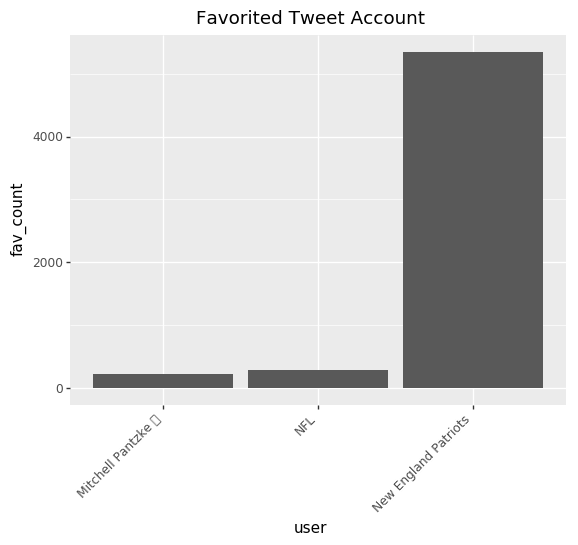

<ggplot: (-9223363259298242651)>

In [111]:
from plotnine import *


#dodge_text = position_dodge(width=0.9)  

(ggplot(tweets_df[tweets_df['fav_count'] > 200],
       aes(x='user',y='fav_count')) + 
       geom_col() + theme(axis_text_x=element_text(rotation=45, hjust=1)) + 
      ggtitle('Favorited Tweet Account'))

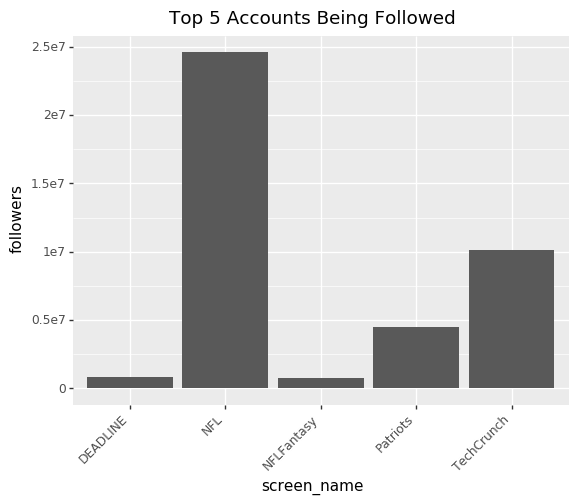

<ggplot: (-9223363259298258821)>

In [113]:
(ggplot(tweets_df.sort_values(by='followers',ascending=False).head(5),
       aes(x='screen_name',y='followers')) + 
       geom_col() + theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      ggtitle('Top 5 Accounts Being Followed'))

In [114]:
# Connect to state population data
import io
import requests

url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/national/totals/nst-est2018-alldata.csv"
response = requests.get(url).content
pop = pd.read_csv(io.StringIO(response.decode('utf-8')))
pop.set_index('NAME', inplace=True)
pop.drop(['United States', 'Northeast Region', 'Midwest Region', 'South Region', 'West Region', 'Puerto Rico'], inplace=True, axis=0)
wi_pop = pop['POPESTIMATE2018']['Wisconsin']
il_pop = pop['POPESTIMATE2018']['Illinois']

print("WI pop: ", wi_pop, sep="")
print("IL pop: ", il_pop, sep="")

# identify tweets in the dataframe that contain the teams that played on that day
chi_tweets = tweets_df[tweets_df['tweet'].str.contains("(chicago)|(bears)|(chi)\W", case=False, regex=True)]
gb_tweets = tweets_df[tweets_df['tweet'].str.contains("(green)|(bay)|(packers)|(gb)\W", case=False, regex=True)]

WI pop: 5813568
IL pop: 12741080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [115]:
print("Tweets where Chicago is mentionede:")
print("Number of tweets - ", chi_tweets.shape[0], sep="")
chi_tweets.head(5)

Tweets where Chicago is mentionede:
Number of tweets - 462


,tweet,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name
1,Rewatching this @Packers @ChicagoBears Preseas...,Sep,07,01,1,0,0,0,0,198,1820,Aaron's Stache & Denim,AmbiguousThug
6,Check out all of #DaBears fans kicking off #Be...,Sep,07,01,1,1,0,0,0,820,382,Blakeway Panoramas,panoramascom
9,RT @FitzyGFY: Dear @nfl - we appreciate you pu...,Sep,07,01,1,0,0,0,215,71,362,Steve Valley,stevevals
13,RT @NFL: A five-sack evening for that @Chicago...,Sep,07,01,1,0,0,0,134,0,8,demitri,demitri55755484
22,RT @NFL: .@Mtrubisky10 warming up for the #NFL...,Sep,07,01,1,0,0,0,69,318,360,Melissa Jones,lisser6370


In [116]:
print("Tweets where Green Bay is mentioned:")
print("Number of tweets - ", gb_tweets.shape[0], sep="")
gb_tweets.head(5)

Tweets where Green Bay is mentioned:
Number of tweets - 419


,tweet,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name
1,Rewatching this @Packers @ChicagoBears Preseas...,Sep,07,01,1,0,0,0,0,198,1820,Aaron's Stache & Denim,AmbiguousThug
9,RT @FitzyGFY: Dear @nfl - we appreciate you pu...,Sep,07,01,1,0,0,0,215,71,362,Steve Valley,stevevals
26,RT @AllEliteHeat: Football season kicks off to...,Sep,07,01,1,0,0,0,7,1,0,🧩,realstevebutler
40,So I just noticed the #NFLNetwork has the #Bea...,Sep,07,00,1,1,1,0,0,1063,713,𝗡𝗢𝗧 𝗧𝗔𝗞𝗘𝗦 𝗙𝗮𝗻𝘁𝗮𝘀𝘆 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹,NOTTakesFF
60,RT @packers: The #NFL100 season begins with a ...,Sep,07,00,1,0,0,0,7158,39,96,emerald eyes,NatalieNwavrick


In [118]:
# Print string describing what is found in the population vs tweet analysis.
# Include variables in the following order in the String.format() method:
#   il_pop
#   wi_pop
#   chi_tweets.shape[0]
#   gb_tweets.shape[0]
#   chi_tpc
#   gb_tpc
#   tpc_dif

chi_tpc = chi_tweets.shape[0] / il_pop
gb_tpc = gb_tweets.shape[0] / wi_pop
tpc_dif = gb_tpc / chi_tpc

print("The estimated population of Illinois is {:,}, and the estimated population of Wisconsin is {:,}.\nAt the time of extracting tweets on September 5, 2019, opening day for the NFL's one hundredth season, there were {:,} tweets mentioning the Chicago Bears and {:,} tweets mentioning the Green Bay Packers.\nThat's a tweet-per-capita rate of {:0.6f} for Illinois and {:0.6f} for Wisconsin. Wisconsin's tweets-per-capita is {:.2f} times greater than Illinois's!\nThis is unexpected as Illinois's population is so much greater than Wisonsins. This may also highlight both the national following of the Green Bay Packers as well as loyalty to the team across all of Wisconsin.".format(il_pop, wi_pop, chi_tweets.shape[0], gb_tweets.shape[0], chi_tpc, gb_tpc, tpc_dif))

The estimated population of Illinois is 12,741,080, and the estimated population of Wisconsin is 5,813,568.
At the time of extracting tweets on September 5, 2019, opening day for the NFL's one hundredth season, there were 462 tweets mentioning the Chicago Bears and 419 tweets mentioning the Green Bay Packers.
That's a tweet-per-capita rate of 0.000036 for Illinois and 0.000072 for Wisconsin. Wisconsin's tweets-per-capita is 1.99 times greater than Illinois's!
This is unexpected as Illinois's population is so much greater than Wisonsins. This may also highlight both the national following of the Green Bay Packers as well as loyalty to the team across all of Wisconsin.
